# Decrypting Monoalphabetic Substitution Ciphers

_Author: Benjamin Smith._
_Modified by: Matthieu Lequesne, François Morain._

_Version: 20230914_

_Based on earlier X tutorials by François Morain and Benjamin Smith._

## Introduction

**Monoalphabetic Substitution Ciphers** map individual symbols in the plaintext to symbols in the ciphertext (and back again) using a rule that depends only on the symbol (and not its position, or any other context).

The simplest example is the **Caesar** cipher, which maps each letter to its neighbour in the alphabet:
- plaintext `a` maps to ciphertext `B`,
- plaintext `b` maps to ciphertext `C`,
- plaintext `c` maps to ciphertext `D`,
- ...
- plaintext `z` maps to ciphertext `A`.

_(Note that we always use lower-case letters for plaintext symbols and UPPER-CASE LETTERS for ciphertext symbols.)_

The Caesar cipher uses a very simple key, but for a general substitution cipher guessing the key is out of the question: there are 26! = 403291461126605635584000000 possibilities!

However, substitution ciphers are notoriously insecure.  This is because they preserve a lot of the statistical structure of the plaintext's language.  In particular, the most frequent ciphertext symbols generally represent the most frequent letters of the plaintext (especially when the plaintext is long, so its statistics conform better to general texts in the target language).

Figuring out which ciphertext symbols represent the **most common letters** of the alphabet is relatively easy.  For example, "e" is the most common letter in French and in English, so the most common symbol in the ciphertext probably represents "e"!

The next few most common letters are usually easy to identify, too (though we might have to try a few permutations among them, since their probabilities are actually quite close and hard to distinguish between).

We can also detect common combinations of adjacent symbols: in French, "q" is always followed by "u", but "u" is rarely followed by "q", so we can look for pairs (**bigrams**) `XY` (say) in the ciphertext such that `X` is never followed by any other symbol except `Y`, and `YX` only rarely appears; such an `XY` would be a good candidate for the encryption of `qu`.

It is painful to compute the symbol and bigram frequencies by hand, so we've written some simple code to do this for you.  And since cryptanalysis necessarily involves (a lot of) **trial and error**, we've also included an interactive solving loop that lets you try setting different candidates, print the results, and undo bad guesses.

The more symbols you identify, the more you will see familiar patterns emerge in the plaintext...
- The first few symbols are **easy** to find;
- the next handful are surprisingly **hard**;
- but once you have found them, it will suddenly become surprisingly **easy to finish** the job.

The idea is to **use basic statistics to improve your chances at trial and error**.  You'll need to use a fair amount of intuition for the target language - so if you're a native French speaker, we suggest attempting one of the challenges where the plaintext is in French!

## Getting started

### Setting the target language
Our main tool today is **frequency analysis**: we will exploit the statistical properties of the message's language. Different languages have different expected symbol frequencies, so we should fix a target language once and for all.  

The `language` variable defines the target language.
- By default, we will set `language` to `'fr'` to attack messages written in French.
- Use `'en'` for messages in English, `'de'` for German, `'es'` for Spanish.

In [19]:
language = 'en' # French by default; use 'en' for messages in English, 'de' for German, 'es' for Spanish

### Selecting a target  ciphertext

Now we need to choose a ciphertext to attack.  For this tutorial, we have
- 21 ciphertexts corresponding to French plaintexts: set `target_number` to an integer between 1 and 21 (inclusive)
- 7 ciphertexts corresponding to English plaintexts: set `target_number` to an integer between 1 and 7 (inclusive)
- 3 ciphertexts corresponding to German plaintexts: set `target_number` to an integer between 1 and 3 (inclusive)
- 2 ciphertexts corresponding to Spanish plaintexts: set `target_number` to an integer between 1 and 2 (inclusive)

If you **change your challenge number**, then you need to re-run this cell _and all of the following cells_ (to update the frequency tables and re-start the solver).  The easiest way to do this is to use the "fast-forward" button in Jupyter.

In [20]:
target_number = 5  # By default

# DO NOT MODIFY THE FOLLOWING LINES

# Check parameters are sane before things get out of hand
assert (language == 'fr' and 1 <= target_number <= 21) \
        or (language == 'en' and 1 <= target_number <= 7) \
        or (language == 'de' and 1 <= target_number <= 3) \
        or (language == 'es' and 1 <= target_number <= 2)

# Define ciphertext filename
ciphertext_filename = f'Challenges/substitution/{language}/{target_number:0>2}.txt'  # DO NOT MODIFY THIS LINE

In [21]:
# For the assignment, to import the ciphertext from a specific file
# uncomment the next line and modify the path to the location of the ciphertext on your computer 
ciphertext_filename = "plaintext1.txt"

## A first look at the ciphertext

Let's open the ciphertext file, and have a quick look at the challenge ahead of us:

In [22]:
# DO NOT MODIFY THIS CELL
ciphertext_file = open(ciphertext_filename, 'r')
ciphertext = ciphertext_file.read()
print(ciphertext)

ZGTCSRBQSOGINZRFGPOUZYGOJORCGGPOMOSGBYGZHOSZGTCSSO
UEBHTBIKZRFCRECGLIOSORGGPOOUOWGIZWWQIIORGTCSWQGBYY
EQIZRFECNUZFPGPBQISZGTCSLCIGBYGPOOWBRBHNEIZJOZRLIO
LCICGZBRYBIPCGOTOOKGPOYUCGTCSSOJORYUZFPGSQLCRETZRS
GBRTPBTCSGPZIGNRZROCREPCECJCIZWBSOQUWOICMBJOPZSIZF
PGCRKUOTORGSUBTUNIOSGZRFSOJOICUGZHOSBRGPOTCNBROCWP
UCREZRFBLLBSZGOGPOUZYGSPCYGGPOLBSGOITZGPGPOORBIHBQ
SYCWOFCXOEYIBHGPOTCUUZGTCSBROBYGPBSOLZWGQIOSTPZWPC
IOSBWBRGIZJOEGPCGGPOONOSYBUUBTNBQCMBQGTPORNBQHBJOM
ZFMIBGPOIZSTCGWPZRFNBQGPOWCLGZBRMOROCGPZGICR



**Observe:**
1. We always use UPPER-CASE LETTERS for the ciphertext alphabet
2. We use lower-case letters for the plaintext alphabet
3. **All spaces and punctuation have been removed** from the plaintext before encryption. _(Encrypted spaces would be easy to identify, and then this would immediately reveal the lengths and structures of individual words...  Which is too easy!)_
4. Here, we wrap lines of ciphertext at 50 characters, to try to keep things readable - but this means that words might be broken across lines

### Loading the toolbox

Now we're ready to load the `substitution` module, which contains some useful tools for breaking substitution ciphers, and create a `Solver` object to attack our specific ciphertext.

In [23]:
# DO NOT MODIFY THIS CELL
import substitution  # Today's toolbox
solver = substitution.Solver(ciphertext_filename, language)

## Fundamental Statistics

Before going any further, let's compute and compare some basic statistics on the target language and the ciphertext.  We will refer to these during our cryptanalysis attempt.

### Symbol Frequencies

The first step is to consider individual symbol frequencies.  Symbols with higher/lower frequencies in the ciphertext _should_ correspond to symbols with higher/lower frequencies in the plaintext's language.

The `solver` object can tabulate these for us.

The following table lists the symbols in the target language and in the cipherext in order of frequency.
- The **Expected** column tells you how many times you would expect that symbol to appear in an average plaintext of the same length as the ciphertext
- The **Occurrences** column tells you how many times the symbol actually appeared in the ciphertext.
- The first row usually gives you a strong idea of which ciphertext symbol corresponds to the plaintext letter 'e'...
- ...but after that, the data is a little too fuzzy to form any strong hypotheses.

In [24]:
solver.symbol_frequencies()  # DO NOT MODIFY

,"Symbol in ""en""",Expected,Ciphertext Symbol,Occurrences
Rank,,,,
1,e,61,O,59
2,t,45,G,55
3,a,39,B,38
4,o,37,C,38
5,i,35,Z,35
6,n,35,R,33
7,s,32,P,32
8,r,30,S,31
9,h,27,I,28


A visual comparison might help.  First, let's look at a histogram of symbols in a hypothetical or average plaintext of the given length:

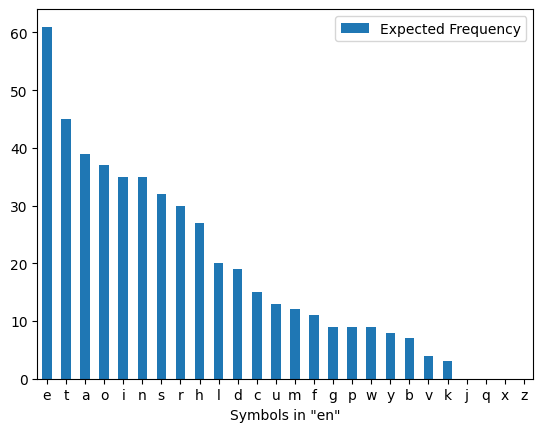

In [25]:
solver.language_histogram()  # DO NOT MODIFY

Now let's look at the histogram of symbol frequencies in the ciphertext: 

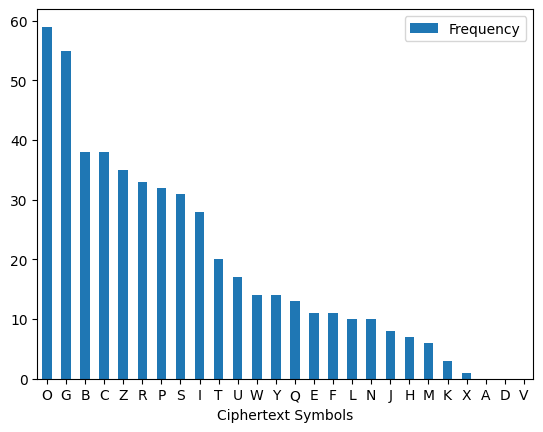

In [26]:
solver.ciphertext_histogram()  # DO NOT MODIFY

### Bigram Frequencies

A **bigram** is a pair of adjacent symbols.

First, let's ask the `solver` to tabulate bigram frequencies for the target language.
- **Columns** correspond to the first letter in the bigram
- **Rows** correspond to the second letter
- The frequencies are **normalized** to give the number of occurrences of each bigram you would _expect_ to see in an average plaintext of the same length as the target ciphertext.
- For example: 'q' is virtually always followed by 'u', so the bigram 'qu' is quite frequent.  On the other hand, the bigram 'uq' is quite rare.

In [27]:
solver.language_bigrams()

/home/laplace_demon/WorkPlace/courses/crypto/Lab1/substitution.py:313: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df.eq(0)] = ''


,e,t,a,o,i,n,s,r,h,l,d,c,u,m,f,g,p,w,y,b,v,k,j,q,x,z
e,1,4,,,1,3,4,7,12,3,1,2,,2,1,1,1,1,,2,2,1,,,,
t,3,2,6,2,4,5,5,3,1,,1,1,2,,2,,,,1,,,,,,,
a,3,2,,,,2,3,2,4,1,2,2,,2,1,,1,1,,,,,,,,
o,2,5,,1,3,3,3,2,2,1,1,2,,1,1,1,1,,1,,,,,,,
i,1,6,,,,1,2,3,3,2,2,,,1,1,,,1,,,,,,,,
n,5,,8,7,8,,,,,,,,1,,,,,,,,,,,,,
s,7,1,3,1,5,2,2,1,,,1,,2,,,,,,,,,,,,,
r,7,1,4,5,1,,,,,,,,2,,,1,,,,,,,,,,
h,,15,,,,,1,,,,,2,,,,,,2,,,,,,,,
l,2,,3,,1,,,,,2,,,1,,,,1,,,1,,,,,,


Now let's tabulate bigram frequencies in the ciphertext, and compare.

In [28]:
solver.ciphertext_bigrams()

/home/laplace_demon/WorkPlace/courses/crypto/Lab1/substitution.py:324: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df.eq(0)] = ''


,O,G,B,C,Z,R,P,S,I,T,U,W,Y,Q,E,F,L,N,J,H,M,K,X,A,D,V
O,5,4,,,,4,14,7,6,2,2,2,,,,,,1,7,2,2,,1,,,
G,2,4,1,8,7,5,4,5,2,,1,2,6,3,1,1,1,,,1,,1,,,,
B,1,4,,,2,3,3,3,2,1,2,3,2,,1,1,2,4,,2,2,,,,,
C,3,1,,,,1,5,,4,10,2,1,1,1,3,2,3,,1,,,,,,,
Z,1,5,,,,1,5,3,7,2,5,,,,1,,1,1,,,1,1,,,,
R,8,,8,6,9,,,1,,,,,,,,,,1,,,,,,,,
P,1,19,,,,,,1,1,3,,3,,,1,3,,,,,,,,,,
S,8,3,4,7,2,1,,2,1,,,,,2,,1,,,,,,,,,,
I,4,4,3,4,1,,,1,1,,,,1,4,1,,2,1,,,1,,,,,
T,4,7,3,,,1,,2,1,,,,,,1,,,,,1,,,,,,


## Interactive Solving with the "Shell"

Now we launch the substitution **shell**.  This cell contains an interactive loop that lets us iteratively try various partial decryptions and see the results.  (It also includes a few powerful bonus tools, some of which are hidden in the source...  Feel free to hack this!)

To launch the shell, run the following cell.  A guide to using the shell is included just below, followed by some cryptanalysis hints.  

_Depending on your Jupyter environment, you may be able to increase the cell height slightly to avoid too much annoying vertical scrolling..._

In [31]:
# DO NOT MODIFY THIS CELL
sh = substitution.Shell(solver)
sh.cmdloop()

Welcome to the substitution solver.  Type help or ? to list commands.

ZGTCSRBQSOGINZRFGPOUZYGOJORCGGPOMOSGBYGZHOSZGTCSSO
itwasnousetryingtheliftevenatthebestoftimesitwasse
UEBHTBIKZRFCRECGLIOSORGGPOOUOWGIZWWQIIORGTCSWQGBYY
ldomworkingandatpresenttheelectriccurrentwascutoff
EQIZRFECNUZFPGPBQISZGTCSLCIGBYGPOOWBRBHNEIZJOZRLIO
duringdaylighthoursitwaspartoftheeconomydriveinpre
LCICGZBRYBIPCGOTOOKGPOYUCGTCSSOJORYUZFPGSQLCRETZRS
parationforhateweektheflatwassevenflightsupandwins
GBRTPBTCSGPZIGNRZROCREPCECJCIZWBSOQUWOICMBJOPZSIZF
tonwhowasthirtynineandhadavaricoseulcerabovehisrig
PGCRKUOTORGSUBTUNIOSGZRFSOJOICUGZHOSBRGPOTCNBROCWP
htanklewentslowlyrestingseveraltimesonthewayoneach
UCREZRFBLLBSZGOGPOUZYGSPCYGGPOLBSGOITZGPGPOORBIHBQ
landingoppositetheliftshafttheposterwiththeenormou
SYCWOFCXOEYIBHGPOTCUUZGTCSBROBYGPBSOLZWGQIOSTPZWPC
sfacegazedfromthewallitwasoneofthosepictureswhicha
IOSBWBRGIZJOEGPCGGPOONOSYBUUBTNBQCMBQGTPORNBQHBJOM
resocontrivedthattheeyesfollowyouaboutwhenyoumoveb
ZFMIBGPOIZS

## Shell Commands

The main shell commands are
- `help`: Lists available commands.  For more help on a given command, run `help commandname`.
- `quit`: Quits the shell (re-run the cell to restart)
- `show`: Display the ciphertext and the current partial decryption.  Lines of the supposed plaintext appear under the corresponding ciphertext line.  Symbols that have not been assigned yet are marked with `-`.
- `set X y`: Set the ciphertext symbol `X` to decrypt to the plaintext symbol `y`.
- `unset X`: Remove the supposed decryption for `X` (i.e., undo the last `set X ...`)
- `map` lets you `set` multiple symbols in parallel

## Hints

### 1. Find the 'e'

The most common symbol in the plaintext will almost certainly be `e`...  So:
1. Identify the most common symbol in the ciphertext using the frequency tables above,
2. run `set X e`, where `X` is the most common symbol in the ciphertext
3. run `show` to see where the `e`s appear in the plaintext.

### 2. Find the 'qu'

In languages like French and English, `q` is virtually always followed by `u`...  And in French, `qu` is very common (think of "que", "qui", "quoi", "quand", ...)

1. Run the `find_qu` command will look for candidate pairs.
2. For each pair, `find_qu` will list the pair of ciphertext symbols representing the candidate `qu`, then the number of times this pair appears in the ciphertext.  (If you have already `set` something to map to the possible `q` or `u`, then `find_qu` will warn you.)
3. Choose a likely pair (e.g. the top one!): if this is `XY`, for example, then you can run `set X q` and `set Y u`.  Alternatively, `map XY qu` will do this in one command.
4. Now `show` the results...

### 3. Find vowels

Gaines' method will identify probable consonants: the command `consonants` will give you a useful hint here. It is wise to use it in conjunction with Sukhotin's method that tries to idenfity vowels. The command `vowels` does this and prints tables of bigrams made of vowels, both in the ciphertext and the reference language.

In french, finding `qu` is best done finding `ou` at the same time.

### 4. Try some frequent letters

Now look at some other frequent letters, or frequent bigrams, and try to match them up... Each language has its own peculiarities that can help breaking this kind of encryption most of the time.

**Run `show` each time you `set` a symbol**, to see if the partial decryption confirms your suspicions. If you think you've made a mistake, you can always undo it with `unset`.

#### Hints for French

- For example: `le` is very common - much more common than `el`, and at this point you've already identifed `e`, so you can try to find `l` in the bigram table...
- Similarly, `en` is very common, and `ne` is quite common too... Can you find and match up other pairs?
- You can also try matching up some of the more common individual symbols using the frequency tables at the top.  You've already found the easiest letter, `e`, but you can probably identify a handful of candidates for `a`, `s`, `i`, `n`, and `t` (the next five most common symbols in French...)

#### Hints for English

`th` dominates every other pair, and is much more frequent than `ht`. It is also possible to locate `th?t` or `th?s` or `the?e` or `th?se` and also of course `the`.

#### Hints for German

`ch` is much more frequent than `hc`; followed by `sch`, `ck`.

### 5. Use your eyes (and your brain!)

Solving monoalphabetic ciphers is a **probabilistic** process.  Run `show` frequently, and see if you can spot parts of familiar words appearing in the plaintext.  The further you go, the easier it will get.  

If one of your early `set` commands reveals one of the first few letters of the ciphertext, then it might give you an idea for the possible first word of the plaintext.  

For example: suppose you have identified the `e`, and now your partial plaintext starts with `-e--`.  What words might appear at the beginning of a text, with second letter `e`?  `Le...`, `Ce...`, `Cet...`, `Cest...`, `De...`, `Je...`, `Ne...`, all come to mind...  And you may be able to decide which one(s) are more likely to be correct based on the frequency of the first symbol in the ciphertext, and of the bigrams it forms with `e`. 

### 6. Be patient!

Cryptanalysis is hard.  Don't be put off by this! Keep trying, and **ask us for help** if you need more hints or encouragement! 

